<table align="center">
   <td align="center"><a target="_blank" href="https://colab.research.google.com/github/ds5110/summer-2021/blob/master/09d-classification-metrics-iris.ipynb">
<img src="https://github.com/ds5110/summer-2021/raw/master/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
</table>


# 09d -- classification metrics - iris 

This builds from [09a-naive-bayes-iris.ipynb](https://github.com/ds5110/summer-2021/blob/master/09a-naive-bayes-iris.ipynb) and  [09c-logistic-regression-iris.ipynb](https://github.com/ds5110/summer-2021/blob/master/09c-logistic-regression-iris.ipynb)


# Logit model (review)

For linear regression
$$
y = \beta_0 + \beta_1 x
$$
and
$$
d_i = y_i + \epsilon_i
$$
Warning: notation can become confusing. We're using subscripts for the regression coefficients $\beta_i$. There are $p+1$ of these, where $p$ is the number of features in the model. We are also using subscripts for the data samples, and there are $N$ of these.

Note that with linear regression, $y$ can take on any value from $- \infty $ to $+ \infty$. With logistic regression, we're modeling classes that have one of two values, yes/no or 0/1 or the equivalent. The data can take on one of these values with a certain probability that varies between 0 and 1. With logistic regression, we model the log-odds as a linear function of $y = \beta_0 + \beta_1 x$. 
$$
\mathrm{log} \left( \frac{p}{1-p} \right) = \mathrm{logit}(p) = y
$$
Since p can vary from 0 to 1, the log odds varies from $- \infty $ to $+ \infty$.
This is where the term logistic regression comes from. We're "fitting" a line to the log-odds. 


We can solve this equation for $p(y)$
$$
p(y) = \frac{1}{1 + e^{-y}} = \mathrm{sigmoid(y)}
$$

Here's the rub: $p$ is a conditional probability. Specifically, $p(1|x)$ is the probability that the true class is 1 given the observation $x$.

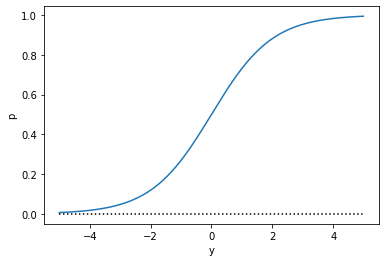

In [ ]:
# Plotting sigmoid(y)
import matplotlib.pyplot as plt
import numpy as np

y = np.arange(-5,5,.01)
p = 1 / (1 + np.exp(-y))

plt.plot(y, p)
plt.plot([-5, 5], [0, 0], ":k")
plt.ylabel("p")
plt.xlabel("y");

# Iris dataset

Load the dataset from scikit learn and verify things.

In [ ]:
# Quickly load and visualize the data with seaborn
import seaborn as sns

df = sns.load_dataset("iris")

#sns.pairplot(df, hue="species");

In [ ]:
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


# 1-D Logistic Regression

* simplified logistic regression using 2 classes and 1 feature
* fit: $y = \beta_0 + \beta_1 x$
* where: $y = \mathrm{logit}(p) = \mathrm{log}\left(\frac{p}{1-p}\right)$



In [ ]:
# Extract data from the dataframe (classes are strings)
import pandas as pd

X = df.iloc[:, :2].values
Y = df['species']
Y = pd.factorize(Y)[0] # Convert strings to 0/1/2

In [ ]:
# Feature scaling -- it won't affect the solution, but it makes plotting easier
# It's a standard preprocessing step, especially with large, multi-dimensional problems
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

In [ ]:
# Pull out 1 feature
feature_index = 0
X_1D = np.expand_dims(X_std[:, feature_index], axis=1)
X_1D.shape # Confirm dimensions needed for scikit-learn API

(150, 1)

# Unbalanced datasets

By varying "n" in the next cell, you can "unbalance" the dataset.

* `n = 100` -- balanced
* `50 < n < 100` -- unbalanced
* try: `n = 60` -- turns out: precision = 1, recall = 0.6

In [ ]:
# Only the first 2 classes (iris data are sorted by class, 50 samples each)
n = 60 # balanced with n = 100, unbalanced for 50 < n < 100
X_1D = X_1D[:n, :]
y_1D = Y[:n]

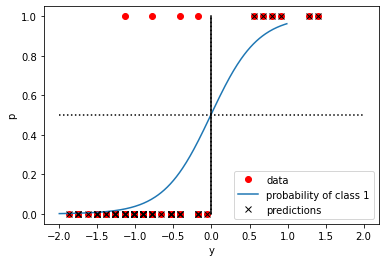

In [ ]:
# 1-D logistic regression with scikit-learn
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1e5)
lr.fit(X_1D, y_1D)
y_pred = lr.predict(X_1D)

# Plot data values with filled red circles
plt.plot(X_1D, y_1D, 'ro', label='data')

# Extract the weights from the model
beta_0 = lr.intercept_
beta_1 = lr.coef_[0]
x = np.arange(-2,1,.01)
y = beta_0 + beta_1 * x
p = 1 / (1 + np.exp(-y))

# Plot the probability of class 1
plt.plot(x, p, label='probability of class 1');

# Plot the predicted values from the data
plt.plot(X_1D, y_pred, 'xk', label='predictions')

# Plot the y-axis passing through the origin
plt.plot([0, 0], [0, 1], 'k')

# Plot the decision boundary (dotted vertical line)
# Note: this corresponds to p=.5, i.e., y=0, which is x= -beta_0/beta_1
x_0 = - beta_0 / beta_1
plt.plot([x_0, x_0], [0, 1], ':k')

# Plot the line y=.5 (dotted horizontal line)
plt.plot([-2, 2], [0.5, .5], ':k')
plt.legend()
plt.xlabel('y')
plt.ylabel('p');

# Confusion matrix

Recall: we used the confusion matrix with naive Bayes classification in [09a-naive-bayes-iris.ipynb](https://github.com/ds5110/summer-2021/blob/master/09a-naive-bayes-iris.ipynb)

For 2 classes, a classification model has 4 possible categories of predictions:

* TP = True Positives = # of predicted positives that are correct
* FP = False Positives = # of predicted positives that are wrong
* TN = True Negatives =  # of predicted negatives that are correct
* FN = False Negatives = # of predicted negatives that are wrong

These correspond to entries in the 2-by-2 "confusion matrix", $C_{ij}$ as follows:

* $ C_{ij} $ = # of observations known to be in class "i" (row) and predicted to be in class "j" (column)
* Unless explicitly specified with the "labels" keyword, classes are in sorted order.
* Therefore, if classes are (0,1):
  * $C_{0, 0}$ = TN
  * $C_{0,1}$ = FP
  * $C_{1,0}$ = FN
  * $C_{1,1}$ = TP
* You can extract these explicitly with `.ravel()`
  * `tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()`
  * Note: default unpacking with `.ravel()` is C-style (outer index cycles fastest)
* P = TP + FN = total # of known positives in the dataset
* N = TN + FP = total # of known negatives in the dataset

### References

* [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) API reference -- scikit-learn.org
* [sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) -- scikit-learn.org
* [Confusion matrix with digits using naive Bayes](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.02-Introducing-Scikit-Learn.ipynb) (jakevdp) -- github



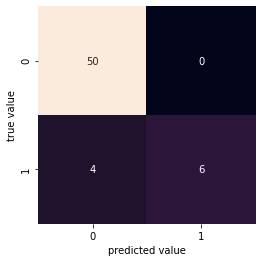

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

mat = confusion_matrix(y_1D, y_pred)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

# Accuracy

$$
 \text{accuracy} 
  = \frac{\text{TP + TN}}{\text{TP + TN + FP + FN}}
  = \frac{\text{# of correct predictions}}{\text{total # of samples in the dataset}} 
$$

* Important: for unbalanced datasets, "accuracy" may be misleading.
* For example: With a 100-sample dataset that has only 10 TP, a model that predicts only negative has an accuracy of 90%!

# Other metrics


For applications in medical/diagnostic screening...

* Sensitivity -- Answers: How well do you predict the positive class? (diabetes cases)

$$ 
\text{sensitivity} 
  = \frac{\text{TP}}{\text{TP + FN}}
  = \frac{\text{# of correctly predicted positives}}{\text{total # of positives in the dataset}}
$$

* Specificity -- Answers: How well do you predict the negative class (no disease)?

$$ 
\text{specificity} 
  = \frac{\text{TN}}{\text{TN + FP}}
  = \frac{\text{# of correctly predicted negatives}}{\text{total # of negatives}}
$$

For search engines, spam detection, etc...

* Precision -- Answers the question: Of all the predicted positives, what fraction are true positive?
$$ 
\text{precision} 
  = \frac{\text{TP}}{\text{TP + FP}}
  = \frac{\text{# of true positives}}{\text{total # of predicted positives}}
$$

* Recall -- Same as Sensitivity

True positive rate (TPR) & False positive rate (FPR)...

* P = TP + FN = Total # of positives in the dataset
* N = TN + FP = Total # of negatives in the dataset


$$
\text{True Positive Rate = Recall = Sensitivity} 
  = \frac{\text{TP}}{\text{P}}
$$


$$
\text{False Positive Rate = (1 - Specificity)} 
  = \frac{\text{FP}}{\text{N}}
$$

* If we optimize for Recall (Sensitivity), we want high TP and low (TP + FN). We can accomplish this while increasing FP, which will cause dismay among patients who test positive but are normal.
* If we optimize for Precision to keep the FP low and TP high, then this can be accomplished while making FN high (i.e., missing a diagnosis of disease, which could have dire consequences).
* The "F1 score" balances these tradeoffs
$$
\text{F1} 
  = 2 \ \frac{\text{precision} \times \text{recall}}{\text{(precision + recall)}}
$$


In [ ]:
# EXERCISE: Investigate the way the metrics change for an unbalanced dataset 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy: %.3f' % accuracy_score(y_true=y_1D, y_pred=y_pred))
print('Precision: %.3f' % precision_score(y_true=y_1D, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_1D, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_1D, y_pred=y_pred))

Accuracy: 0.933
Precision: 1.000
Recall: 0.600
F1: 0.750


# ROC & AUC

Receiver Operating Characteristic (ROC) and Area Under the Curve (AUC)

ROC visualizes the tradeoff between sensitivity and specificity as you change the decision threshold.

* [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

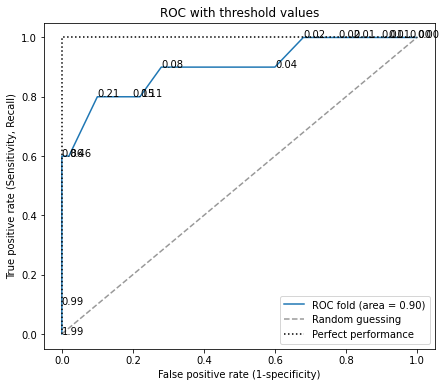

In [ ]:
from sklearn.metrics import roc_curve, auc

fig = plt.figure(figsize=(7, 6))

# the .predict_proba() method returns class probabilities
probas = lr.fit(X_1D, y_1D).predict_proba(X_1D)

fpr, tpr, thresholds = roc_curve(y_1D, probas[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC fold (area = {:0.2f})'.format(roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

for i, (f, t, z) in enumerate(zip(fpr, tpr, thresholds)):
  plt.text(f, t, '{:.2f}'.format(z))

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('ROC with threshold values')
plt.xlabel('False positive rate (1-specificity)')
plt.ylabel('True positive rate (Sensitivity, Recall)')
plt.legend(loc="lower right");

# Pipelines

* Combine preprocessing and modeling in a single object
* We'll use a pipeline to streamline cross-validation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(random_state=1, solver='lbfgs'))

pipe_lr.fit(X_1D, y_1D)
y_pred = pipe_lr.predict(X_1D)
print('Test Accuracy: %.3f' % pipe_lr.score(X_1D, y_1D))

Test Accuracy: 0.933


# Cross validation (review)

* Recall: 07-Modeling2-validation.ipynb
  * We looked at `validation_curve` with a simulated dataset
  * Model complexity & bias-variance tradeoff (polynomial least squares)
  * Cross-validation was built into [`sklearn.model_selection.validation_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)
  * We set the CV strategy with `cv=7`, which uses [`sklearn.model_selection.StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)
    * Stratified K-Folds cross-validator provides train/test indices to split data in train/test sets.
    * This variation of the KFold cross-validation object returns stratified folds. 
    * The folds are made by preserving the percentage of samples for each class.

In [ ]:
from sklearn.model_selection import StratifiedKFold
    
kfold = StratifiedKFold(n_splits=10).split(X_1D, y_1D)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_1D[train], y_1D[train])
    score = pipe_lr.score(X_1D[test], y_1D[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_1D[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [45  9], Acc: 1.000
Fold:  2, Class dist.: [45  9], Acc: 1.000
Fold:  3, Class dist.: [45  9], Acc: 1.000
Fold:  4, Class dist.: [45  9], Acc: 0.833
Fold:  5, Class dist.: [45  9], Acc: 1.000
Fold:  6, Class dist.: [45  9], Acc: 0.833
Fold:  7, Class dist.: [45  9], Acc: 1.000
Fold:  8, Class dist.: [45  9], Acc: 0.833
Fold:  9, Class dist.: [45  9], Acc: 1.000
Fold: 10, Class dist.: [45  9], Acc: 0.833

CV accuracy: 0.933 +/- 0.082


In [ ]:
# StratifiedKFold returns a "generator" -- inspect it with list()
kfold = StratifiedKFold(n_splits=10).split(X_1D, y_1D)
#list(kfold)

In [ ]:
# This cell shows that cross validation is built into the cross_val_score object
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                         X=X_1D,
                         y=y_1D,
                         cv=10,
                         n_jobs=1)
[print('CV accuracy score: {:.3f}'.format(score)) for score in scores]
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy score: 1.000
CV accuracy score: 1.000
CV accuracy score: 1.000
CV accuracy score: 0.833
CV accuracy score: 1.000
CV accuracy score: 0.833
CV accuracy score: 1.000
CV accuracy score: 0.833
CV accuracy score: 1.000
CV accuracy score: 0.833
CV accuracy: 0.933 +/- 0.082


# Hyperparameter tuning with cross validation

We can use `GridSearchCV` or `validation_curve` to find the optimal value for regularization (hyper)parameter "C"

* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) -- scikit-learn.org
* [validation_curve](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html) -- scikit-learn.org

As you can see in the demos, each of these uses a special syntax to define the hyperparameters that they search:

* [parameter spaces](https://scikit-learn.org/stable/modules/grid_search.html#composite-estimators-and-parameter-spaces) and naming syntax -- scikit-learn.org
* [pipeline chaining](https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators) -- scikit-learn.org

Best parameter {'logisticregression__C': 1.0}


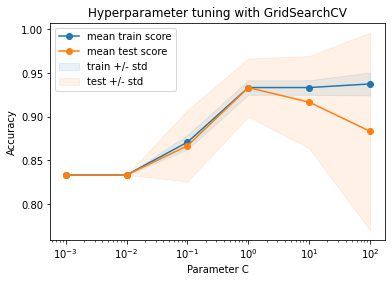

In [70]:
# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define parameters for grid search
param_range = np.logspace(-3, 2, 6)
params = {'logisticregression__C': param_range}

# Default is 5-fold StratifiedKFold cross validation
gs = GridSearchCV(pipe_lr, params, return_train_score=True)
gs.fit(X_1D, y_1D)

# Note: The default is C=1 for LogisticRegression
print('Best parameter', gs.best_params_) # best value for is C=1

# Get results from a cs_results dictionary
train_scores_mean = gs.cv_results_['mean_train_score']
train_scores_std = gs.cv_results_['std_train_score']
test_scores_mean = gs.cv_results_['mean_test_score']
test_scores_std = gs.cv_results_['std_test_score']

# plot results
plt.semilogx(param_range, train_scores_mean, marker='o', label='mean train score')
plt.semilogx(param_range, test_scores_mean, marker='o', label='mean test score')

# plot spread
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.fill_between(param_range, train_scores_mean + train_scores_std,
                 train_scores_mean - train_scores_std, alpha=0.1,
                 color=colors[0], label='train +/- std')

plt.fill_between(param_range, test_scores_mean + test_scores_std,
                 test_scores_mean - test_scores_std, alpha=0.1,
                 color=colors[1], label='test +/- std')
plt.title('Hyperparameter tuning with GridSearchCV')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend();

(6, 5) (6, 5)


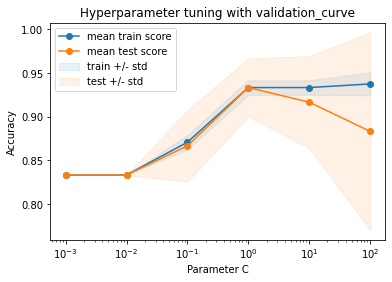

In [68]:
# Hyperparameter tuning with validation_curve
# This produces the same result as above, but with different syntax
from sklearn.model_selection import validation_curve

param_range = np.logspace(-3, 2, 6)

# validation_curve uses default 5-fold cross validation
train_scores, test_scores = validation_curve(
    pipe_lr, X_1D, y_1D, 
    param_name="logisticregression__C", 
    param_range=param_range,
    scoring="accuracy", n_jobs=1)

# train_scores & test_scores have dimension n_parameters-by-n_folds
print(train_scores.shape, test_scores.shape)

# Compute CV-averaged training accuracy
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot results
plt.semilogx(param_range, train_scores_mean, marker='o', label='mean train score')
plt.semilogx(param_range, test_scores_mean, marker='o', label='mean test score')

# plot spread
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.fill_between(param_range, train_scores_mean + train_scores_std,
                 train_scores_mean - train_scores_std, alpha=0.1,
                 color=colors[0], label='train +/- std')

plt.fill_between(param_range, test_scores_mean + test_scores_std,
                 test_scores_mean - test_scores_std, alpha=0.1,
                 color=colors[1], label='test +/- std')
plt.title('Hyperparameter tuning with validation_curve')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend();

# ROC with Cross Validation

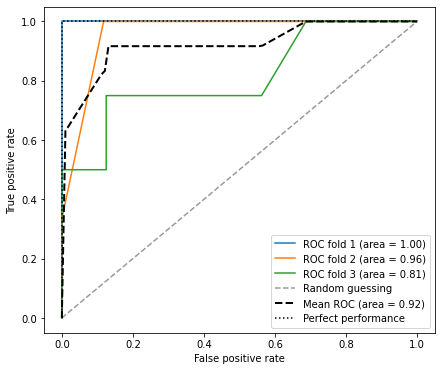

In [ ]:
from numpy import interp
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

cv = list(StratifiedKFold(n_splits=3).split(X_1D, y_1D))

fig = plt.figure(figsize=(7, 6))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_1D[train],
                         y_1D[train]).predict_proba(X_1D[test])

    fpr, tpr, thresholds = roc_curve(y_1D[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right");